In [1]:
import sys
import os
import glob
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve as FFTConv
from scipy.special import wofz
from pymatgen.io import cif as cif
from pymatgen.analysis.diffraction import xrd as pmg
import seaborn as sns

def gaussian(x,background,height,position,FWHM):
    std = FWHM/2*np.sqrt(2*np.log(2))

    return background+height*np.exp(-1*(x-position)**2/(2*std**2))

def Lorentz(x,background,height,position,HWHM):
	"""
	Returns a Lorenztian with the background, the height, the position and HWHM of the peaks
	"""
	return background + height*(HWHM/np.pi/((x-position)**2+HWHM**2))

def Voigt(x,background,height,position,alpha,gamma):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.

    """
    sigma = alpha/np.sqrt(2*np.log(2))

    return background+height*np.real(wofz(((x-position)+1j*gamma)/sigma/np.sqrt(2)))/sigma/np.sqrt(2*np.pi)


# Point to the CIFs and the DPs and set the Q range

In [26]:
ptdata = '/home/duncan/Documents/Data/RTB-BiO-2015_08_28_sampleB/GADDS_Summary/'
ptCIFs = '/home/duncan/Documents/CIFs/Bi2O3/'
Title = "Bob's Sample B"
Qmin = 20.
Qmax = 60.

20.0 60.0
All phases:
['Delta', 'Beta', 'Alpha']

/home/duncan/Documents/Data/RTB-BiO-2015_08_28_sampleB/GADDS_Summary/RTB_BiO_SampleB_Scan-06_AOI-15_20-50-7.5_60s.xy
/home/duncan/Documents/Data/RTB-BiO-2015_08_28_sampleB/GADDS_Summary/RTB_BiO_SampleB_Scan-05_AOI-15_20-50-7.5_60s.xy
/home/duncan/Documents/Data/RTB-BiO-2015_08_28_sampleB/GADDS_Summary/RTB_BiO_SampleB_Scan-04_AOI-15_20-50-7.5_60s.xy
/home/duncan/Documents/Data/RTB-BiO-2015_08_28_sampleB/GADDS_Summary/RTB_BiO_SampleB_Scan-03_AOI-15_20-50-7.5_60s.xy
/home/duncan/Documents/Data/RTB-BiO-2015_08_28_sampleB/GADDS_Summary/RTB_BiO_SampleB_Scan-02_AOI-15_20-50-7.5_60s.xy
/home/duncan/Documents/Data/RTB-BiO-2015_08_28_sampleB/GADDS_Summary/RTB_BiO_SampleB_Scan-01_AOI-15_20-50-7.5_60s.xy
/home/duncan/Documents/Data/RTB-BiO-2015_08_28_sampleB/GADDS_Summary/RTB_BiO_SampleB_Scan-00_AOI-15_20-50-7.5_60s.xy


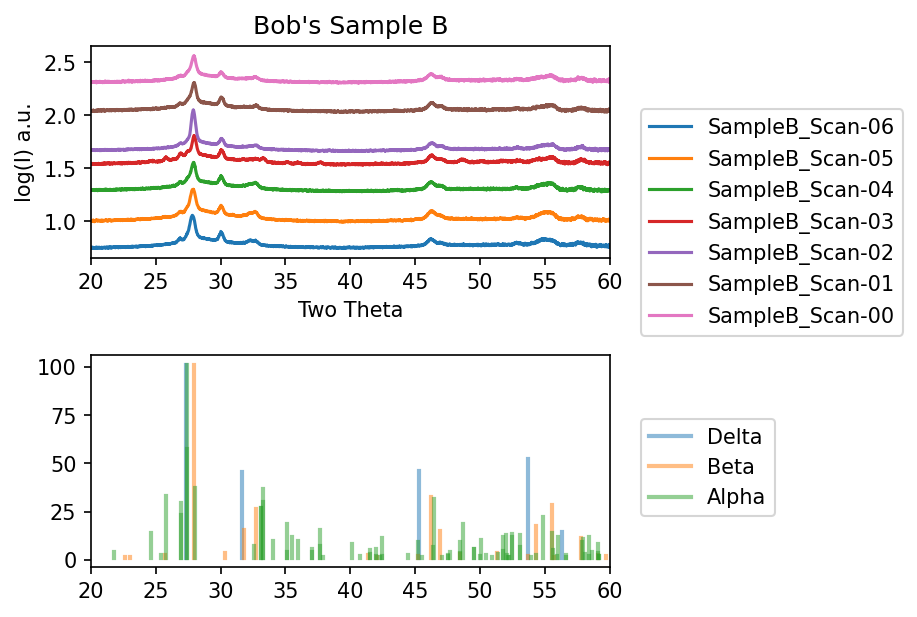

In [28]:
colors = list(sns.color_palette('tab10',16).as_hex())

datapath = sorted(glob.glob(ptdata+'*.xy'))[::-1]
CIFpaths = glob.glob(ptCIFs+'*.cif')
detIm = glob.glob(ptdata+'*.png')

print(Qmin,Qmax)

Structures = {}
for idx, c in enumerate(CIFpaths):
    xtal = os.path.basename(c).split('_')[0]
    Structures[xtal] = cif.CifParser(c).get_structures()[0]

Phases = list(Structures)
print(f'All phases:')
print(Phases)
print('')

fig, ax = plt.subplots(2,1,dpi=150,constrained_layout=True)	
for idx,s in enumerate(datapath):
    print(s)
    fn = os.path.basename(s).split('_')
    scanname = '_'.join([fn[2],fn[3]])
#     scanname = '_'.join([fn[0],fn[1],fn[2]])
    raw = np.genfromtxt(s,delimiter='',skip_header=1)
    
    Q_i = raw[:,0]
    I = np.log10(raw[:,1]+1)
    #filter
    Q = Q_i[(Q_i>=Qmin)&(Q_i<=Qmax)]
    I = I[(Q_i>=Qmin)&(Q_i<=Qmax)]
    #normalize
    I = I/max(I)

    #remove linear background
    m = (I[-1]-I[0])/len(I)

    I = I-m*np.arange(len(I))

#     print(idx,s)
    ax[0].plot(Q,I+0.25*idx,label=scanname,c=colors[idx])
    ax[0].set_xlim(Qmin,Qmax)
    ax[0].set_xlabel('Two Theta')
    ax[0].set_ylabel('log(I) a.u.')

    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles[::-1],labels[::-1])


sim_spec3 = []
for idx, xtal in enumerate(list(Structures)):
    xrdcalc = pmg.XRDCalculator()
    # print(Structures[xtal])
    # print(Structures[xtal].get_structures()[0])
    dp = xrdcalc.get_pattern(Structures[xtal],two_theta_range=(Qmin,Qmax))
    Qs = dp.x
    Is = dp.y

    for pdx, (q,i) in enumerate(zip(Qs,Is)):
        simQ = np.linspace(Qmin,Qmax,len(Q))
        simI3 = Voigt(simQ,0,i,q,0.2,0.1)
        sim_spec3.append(simI3)


        ax[1].plot([q,q],[i+1,1],linewidth=2,c=colors[idx],label=xtal,alpha=0.5)
    ax[1].set_xlim(Qmin,Qmax)
    
handles, labels = ax[1].get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

ax[1].legend(newHandles, newLabels,loc='upper left',bbox_to_anchor=(1.04,0.75))
# ax[0].legend(['no delay','5s delay'],bbox_to_anchor=(1.04,0.75))
ax[0].legend(loc='upper left',bbox_to_anchor=(1.04,0.75))
ax[0].set_title(f'{Title}')
plt.show()